In [1]:
import pandas as pd
import sys
import datetime
import matplotlib.pylab as plt
import numpy as np
from math import log, floor, ceil
from typing import Dict

In [2]:
START_DATE = datetime.date(2020,2,24)

In [3]:
def create_filename(day: datetime.date) -> str:
    day_str = day.strftime("%Y%m%d")
    return ('../dati-province/dpc-covid19-ita-province-' + day_str + '.csv')

In [4]:
def handle_Toscana_20200326_error(cases: Dict[str, int]) -> Dict[str, int]:
    cases['20200327'] = cases['20200326'] + floor((cases['20200328'] - cases['20200326'])/2)
    cases['20200328'] = cases['20200327'] + ceil((cases['20200328'] - cases['20200326'])/2)
    return cases

In [5]:
def calculate_and_create_chart_for_province(start_date: datetime.date, province: str):
    day = start_date
    cases: Dict[str,int] = {}
    while day<=datetime.date.today():
        day_str: str = day.strftime("%Y%m%d")
        filename: str = create_filename(day)
        df: pd.DataFrame = pd.read_csv(filename, encoding = "ISO-8859-1")
        cases[day_str] = int(df[df["denominazione_provincia"]==province]["totale_casi"])
        day: datetime.date = day + datetime.timedelta(days = 1)
    
    if df[df["denominazione_provincia"]==province]["denominazione_regione"].any()=='Toscana':
        cases = handle_Toscana_20200326_error(cases)
    
    cases_df: pd.DataFrame = pd.DataFrame.from_dict(cases, orient='index')
    cases_df = cases_df.reset_index()
    cases_df = cases_df.rename(columns={"index": "Day", 0: "Cases"})
    
    cases_df_today = cases_df[cases_df["Day"]==datetime.date.today().strftime("%Y%m%d")]["Cases"].sum()
    print("Total cases per 1000 inhabitants up to today:", round(calculate_cases_to_inhabitants_ratio(cases_df_today, province),4))
    calculate_stats(cases_df)

    x = cases_df.index
    y = cases_df["Cases"]
    plt.scatter(x, y)

    z = np.polyfit(x, y, 3)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    plt.grid()

    plt.show()
    return

In [6]:
def calculate_and_create_chart_for_region(start_date: datetime.date, region: str):
    day: datetime.date = start_date
    cases: Dict[str, int] = {}
    while day<=datetime.date.today():
        day_str: str = day.strftime("%Y%m%d")
        filename: str = '../dati-province/dpc-covid19-ita-province-' + day_str + '.csv'
        df: pd.DataFrame = pd.read_csv(filename, encoding = "ISO-8859-1")
        cases[day_str] = int(df[(df["denominazione_regione"]==region)&(df["denominazione_provincia"]!='In fase di definizione/aggiornamento')]["totale_casi"].sum())
        day: datetime.date = day + datetime.timedelta(days = 1)
        
    if region == 'Toscana':
        cases = handle_Toscana_20200326_error(cases)

    cases_df = pd.DataFrame.from_dict(cases, orient='index')
    cases_df = cases_df.reset_index()
    cases_df = cases_df.rename(columns={"index": "Day", 0: "Cases"})
    
    calculate_stats(cases_df)

    x = cases_df.index
    y = cases_df["Cases"]
    plt.scatter(x, y)

    z = np.polyfit(x, y, 3)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    plt.grid()
    plt.yscale("log")
    plt.show()
    return

In [7]:
def calculate_and_create_chart_for_Italy(start_date: datetime.date):
    day: datetime.date = start_date
    cases: Dict[str, int] = {}
    while day<=datetime.date.today():
        day_str: str = day.strftime("%Y%m%d")
        filename: str = '../dati-province/dpc-covid19-ita-province-' + day_str + '.csv'
        df: pd.DataFrame = pd.read_csv(filename, encoding = "ISO-8859-1")
        cases[day_str] = int(df[df["denominazione_provincia"]!='In fase di definizione/aggiornamento']["totale_casi"].sum())
        day: datetime.date = day + datetime.timedelta(days = 1)

    cases_df: pd.DataFrame = pd.DataFrame.from_dict(cases, orient='index')
    cases_df = cases_df.reset_index()
    cases_df = cases_df.rename(columns={"index": "Day", 0: "Cases"})
    
    calculate_stats(cases_df)

    x = cases_df.index
    y = cases_df["Cases"]
    plt.scatter(x, y)

    z = np.polyfit(x, y, 3)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    plt.grid()

    plt.show()
    return

In [8]:
def calculate_stats(cases_df):
    cases_df_today = cases_df[cases_df["Day"]==datetime.date.today().strftime("%Y%m%d")]["Cases"].sum()
    cases_df_yesterday = cases_df[cases_df["Day"]==(datetime.date.today()- datetime.timedelta(days = 1)).strftime("%Y%m%d")]["Cases"].sum()
    cases_df_five_days_ago = cases_df[cases_df["Day"]==(datetime.date.today()- datetime.timedelta(days = 5)).strftime("%Y%m%d")]["Cases"].sum()
    cases_df_six_days_ago = cases_df[cases_df["Day"]==(datetime.date.today()- datetime.timedelta(days = 6)).strftime("%Y%m%d")]["Cases"].sum()
    print("Total cases up to today:", cases_df_today)
    print("New cases registered today:", cases_df_today-cases_df_yesterday)
    if int(cases_df_yesterday) != 0:
        print("New cases registered today in %:", round((cases_df_today-cases_df_yesterday)/cases_df_yesterday*100,2))

    print("Doubling time in the last five days:", round(calculate_doubling_time_in_the_last_five_days(cases_df_today, cases_df_five_days_ago), 1))
    print("Doubling time yesterday:", round(calculate_doubling_time_in_the_last_five_days(cases_df_yesterday, cases_df_six_days_ago), 1))
    print("Trend of new cases (in %) in the last 5 days:", round((cases_df_today-cases_df_five_days_ago)/cases_df_five_days_ago*100,2))
    
    return

In [9]:
def calculate_doubling_time_in_the_last_five_days(cases_df_today, cases_df_five_days_ago):
    if cases_df_five_days_ago ==0:
        return np.nan
    log_result = log(cases_df_today/cases_df_five_days_ago)
    if log_result != 0:
        return (5*log(2))/(log_result)
    else:
        return np.nan
    

In [10]:
def calculate_cases_to_inhabitants_ratio(cases: int, province: str) -> float:
    df_province: pd.DataFrame = pd.read_csv("../general/province.csv")
    inhabitants = df_province[df_province["Provincia"]==province]["Residenti"].str.replace('.', '', regex=True).sum()
    return int(cases)/int(inhabitants)*1000

# Casi di COVID-19 in Italia - COVID-19 cases in Italy

Total cases up to today: 89387
New cases registered today: 5890
New cases registered today in %: 7.05
Doubling time in the last five days: 9.5
Doubling time yesterday: 9.3
Trend of new cases (in %) in the last 5 days: 44.1


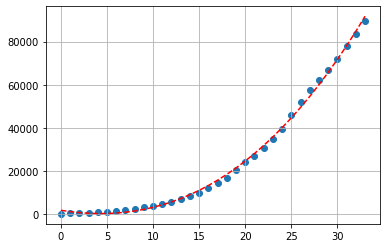

In [11]:
calculate_and_create_chart_for_Italy(START_DATE)

# Casi di COVID-19 in Abruzzo - COVID-19 cases in Abruzzo

Total cases up to today: 1133
New cases registered today: 116
New cases registered today in %: 11.41
Doubling time in the last five days: 6.5
Doubling time yesterday: 6.3
Trend of new cases (in %) in the last 5 days: 70.89


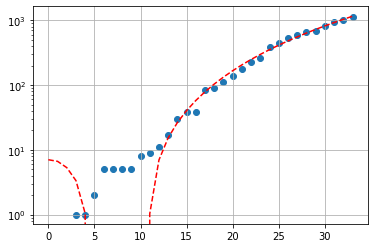

In [12]:
calculate_and_create_chart_for_region(START_DATE, 'Abruzzo')

## Chieti

Total cases per 1000 inhabitants up to today: 0.5884
Total cases up to today: 229
New cases registered today: 40
New cases registered today in %: 21.16
Doubling time in the last five days: 6.0
Doubling time yesterday: 5.6
Trend of new cases (in %) in the last 5 days: 77.52


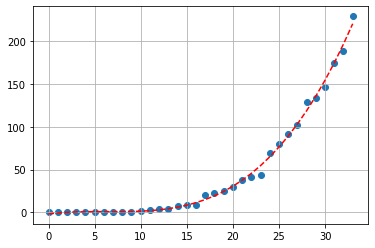

In [13]:
calculate_and_create_chart_for_province(START_DATE, 'Chieti')

## L'Aquila

Total cases per 1000 inhabitants up to today: 0.2915
Total cases up to today: 88
New cases registered today: 13
New cases registered today in %: 17.33
Doubling time in the last five days: 4.4
Doubling time yesterday: 5.1
Trend of new cases (in %) in the last 5 days: 120.0


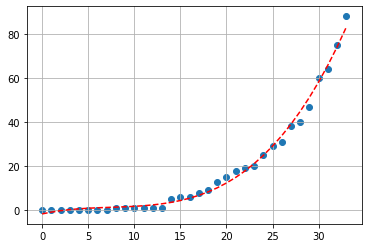

In [14]:
calculate_and_create_chart_for_province(START_DATE, "L'Aquila")

## Pescara

Total cases per 1000 inhabitants up to today: 1.5935
Total cases up to today: 512
New cases registered today: 36
New cases registered today in %: 7.56
Doubling time in the last five days: 10.7
Doubling time yesterday: 9.8
Trend of new cases (in %) in the last 5 days: 38.38


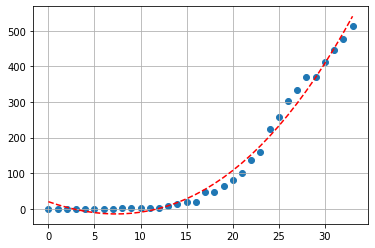

In [15]:
calculate_and_create_chart_for_province(START_DATE, 'Pescara')

## Teramo

Total cases per 1000 inhabitants up to today: 0.9811
Total cases up to today: 304
New cases registered today: 27
New cases registered today in %: 9.75
Doubling time in the last five days: 3.9
Doubling time yesterday: 3.9
Trend of new cases (in %) in the last 5 days: 145.16


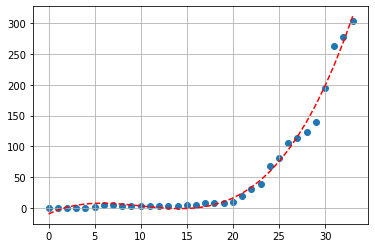

In [16]:
calculate_and_create_chart_for_province(START_DATE, 'Teramo')

# Casi di COVID-19 in Basilicata - COVID-19 cases in Basilicata

Total cases up to today: 182
New cases registered today: 31
New cases registered today in %: 20.53
Doubling time in the last five days: 4.9
Doubling time yesterday: 5.6
Trend of new cases (in %) in the last 5 days: 102.22


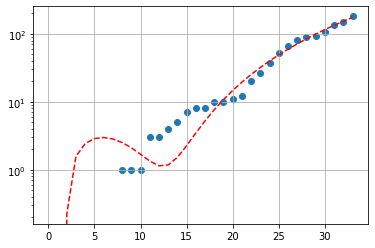

In [17]:
calculate_and_create_chart_for_region(START_DATE, 'Basilicata')

## Matera

Total cases per 1000 inhabitants up to today: 0.3806
Total cases up to today: 76
New cases registered today: 23
New cases registered today in %: 43.4
Doubling time in the last five days: 2.4
Doubling time yesterday: 2.9
Trend of new cases (in %) in the last 5 days: 322.22


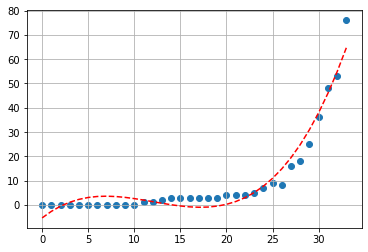

In [18]:
calculate_and_create_chart_for_province(START_DATE, 'Matera')

## Potenza

Total cases per 1000 inhabitants up to today: 0.286
Total cases up to today: 106
New cases registered today: 8
New cases registered today in %: 8.16
Doubling time in the last five days: 9.0
Doubling time yesterday: 8.4
Trend of new cases (in %) in the last 5 days: 47.22


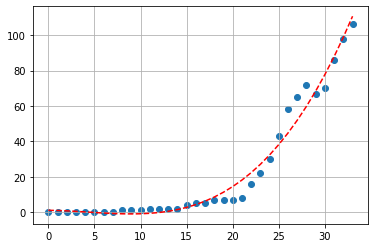

In [19]:
calculate_and_create_chart_for_province(START_DATE, 'Potenza')

# Casi di COVID-19 nella Provincia Autonoma di Bolzano - COVID-19 cases in Autonomous Province of Bolzano

Total cases up to today: 1109
New cases registered today: 106
New cases registered today in %: 10.57
Doubling time in the last five days: 8.1
Doubling time yesterday: 8.9
Trend of new cases (in %) in the last 5 days: 53.18


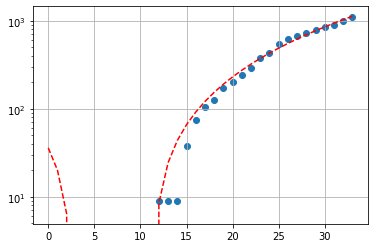

In [20]:
calculate_and_create_chart_for_region(START_DATE, 'P.A. Bolzano')

# Casi di COVID-19 in Calabria - COVID-19 cases in Calabria

Total cases up to today: 553
New cases registered today: 61
New cases registered today in %: 12.4
Doubling time in the last five days: 5.4
Doubling time yesterday: 5.8
Trend of new cases (in %) in the last 5 days: 90.69


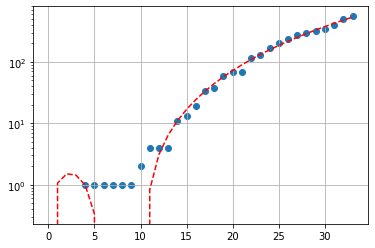

In [21]:
calculate_and_create_chart_for_region(START_DATE, 'Calabria')

## Catanzaro

Total cases per 1000 inhabitants up to today: 0.3257
Total cases up to today: 118
New cases registered today: 3
New cases registered today in %: 2.61
Doubling time in the last five days: 3.7
Doubling time yesterday: 3.7
Trend of new cases (in %) in the last 5 days: 156.52


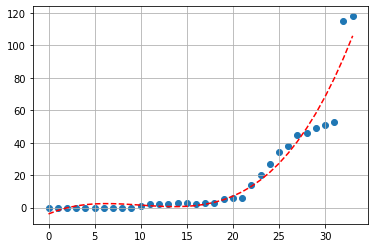

In [22]:
calculate_and_create_chart_for_province(START_DATE, 'Catanzaro')

## Cosenza

Total cases per 1000 inhabitants up to today: 0.2164
Total cases up to today: 154
New cases registered today: 26
New cases registered today in %: 20.31
Doubling time in the last five days: 4.2
Doubling time yesterday: 4.9
Trend of new cases (in %) in the last 5 days: 126.47


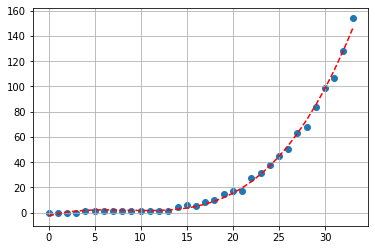

In [23]:
calculate_and_create_chart_for_province(START_DATE, 'Cosenza')

## Crotone

Total cases per 1000 inhabitants up to today: 0.4955
Total cases up to today: 87
New cases registered today: 7
New cases registered today in %: 8.75
Doubling time in the last five days: 10.2
Doubling time yesterday: 12.8
Trend of new cases (in %) in the last 5 days: 40.32


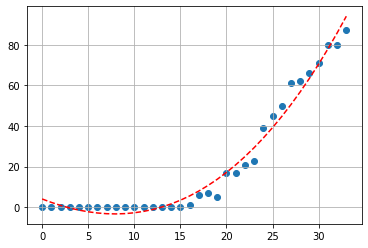

In [24]:
calculate_and_create_chart_for_province(START_DATE, 'Crotone')

## Reggio di Calabria

Total cases per 1000 inhabitants up to today: 0.2799
Total cases up to today: 155
New cases registered today: 15
New cases registered today in %: 10.71
Doubling time in the last five days: 6.9
Doubling time yesterday: 7.5
Trend of new cases (in %) in the last 5 days: 64.89


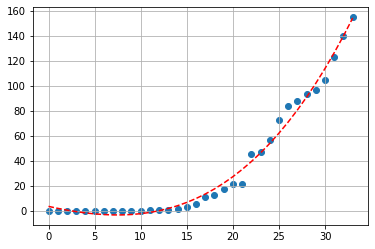

In [25]:
calculate_and_create_chart_for_province(START_DATE, 'Reggio di Calabria')

## Vibo Valentia

Total cases per 1000 inhabitants up to today: 0.2413
Total cases up to today: 39
New cases registered today: 10
New cases registered today in %: 34.48
Doubling time in the last five days: 5.2
Doubling time yesterday: 4.8
Trend of new cases (in %) in the last 5 days: 95.0


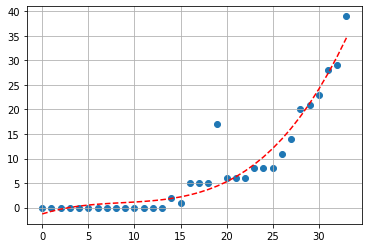

In [26]:
calculate_and_create_chart_for_province(START_DATE, 'Vibo Valentia')

# Casi di COVID-19 in Campania - COVID-19 cases in Campania

Total cases up to today: 1534
New cases registered today: 180
New cases registered today in %: 13.29
Doubling time in the last five days: 8.2
Doubling time yesterday: 9.0
Trend of new cases (in %) in the last 5 days: 52.79


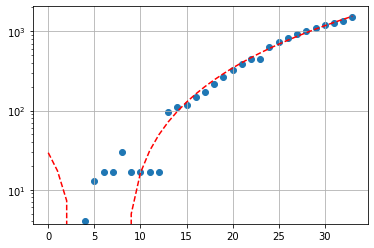

In [27]:
calculate_and_create_chart_for_region(START_DATE, 'Campania')

## Avellino

Total cases per 1000 inhabitants up to today: 0.4557
Total cases up to today: 193
New cases registered today: 11
New cases registered today in %: 6.04
Doubling time in the last five days: 12.1
Doubling time yesterday: 10.8
Trend of new cases (in %) in the last 5 days: 33.1


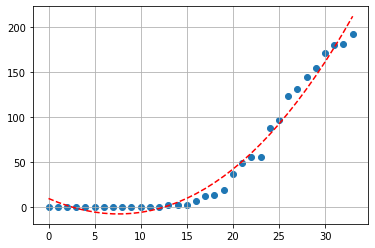

In [28]:
calculate_and_create_chart_for_province(START_DATE, 'Avellino')

## Benevento

Total cases per 1000 inhabitants up to today: 0.0751
Total cases up to today: 21
New cases registered today: 6
New cases registered today in %: 40.0
Doubling time in the last five days: 7.2
Doubling time yesterday: 24.2
Trend of new cases (in %) in the last 5 days: 61.54


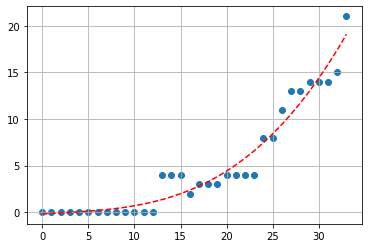

In [29]:
calculate_and_create_chart_for_province(START_DATE, 'Benevento')

## Caserta

Total cases per 1000 inhabitants up to today: 0.2013
Total cases up to today: 186
New cases registered today: 7
New cases registered today in %: 3.91
Doubling time in the last five days: 8.5
Doubling time yesterday: 8.0
Trend of new cases (in %) in the last 5 days: 50.0


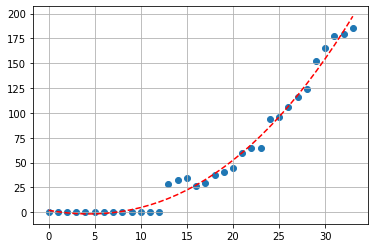

In [30]:
calculate_and_create_chart_for_province(START_DATE, 'Caserta')

## Napoli

Total cases per 1000 inhabitants up to today: 0.2662
Total cases up to today: 827
New cases registered today: 93
New cases registered today in %: 12.67
Doubling time in the last five days: 8.2
Doubling time yesterday: 9.2
Trend of new cases (in %) in the last 5 days: 52.3


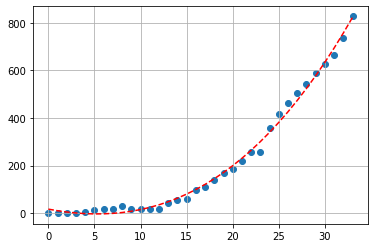

In [31]:
calculate_and_create_chart_for_province(START_DATE, 'Napoli')

## Salerno

Total cases per 1000 inhabitants up to today: 0.2779
Total cases up to today: 307
New cases registered today: 63
New cases registered today in %: 25.82
Doubling time in the last five days: 6.4
Doubling time yesterday: 7.9
Trend of new cases (in %) in the last 5 days: 71.51


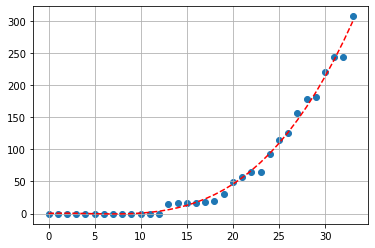

In [32]:
calculate_and_create_chart_for_province(START_DATE, 'Salerno')

# Casi di COVID-19 in Emilia Romagna - COVID-19 cases in Emilia Romagna

Total cases up to today: 12383
New cases registered today: 795
New cases registered today in %: 6.86
Doubling time in the last five days: 9.3
Doubling time yesterday: 8.1
Trend of new cases (in %) in the last 5 days: 45.08


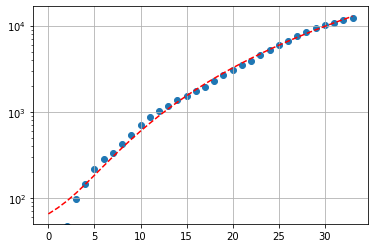

In [33]:
calculate_and_create_chart_for_region(START_DATE, 'Emilia Romagna')

## Bologna

Total cases per 1000 inhabitants up to today: 1.5715
Total cases up to today: 1586
New cases registered today: 173
New cases registered today in %: 12.24
Doubling time in the last five days: 5.4
Doubling time yesterday: 4.7
Trend of new cases (in %) in the last 5 days: 90.4


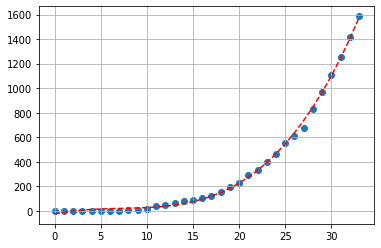

In [34]:
calculate_and_create_chart_for_province(START_DATE, 'Bologna')

## Ferrara

Total cases per 1000 inhabitants up to today: 0.8066
Total cases up to today: 281
New cases registered today: 37
New cases registered today in %: 15.16
Doubling time in the last five days: 7.1
Doubling time yesterday: 7.1
Trend of new cases (in %) in the last 5 days: 63.37


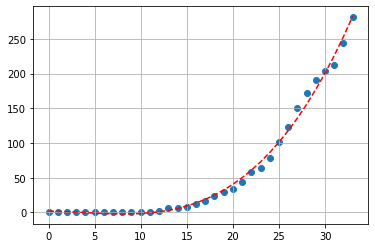

In [35]:
calculate_and_create_chart_for_province(START_DATE, 'Ferrara')

## Modena

Total cases per 1000 inhabitants up to today: 2.7423
Total cases up to today: 1922
New cases registered today: 150
New cases registered today in %: 8.47
Doubling time in the last five days: 6.8
Doubling time yesterday: 6.2
Trend of new cases (in %) in the last 5 days: 66.41


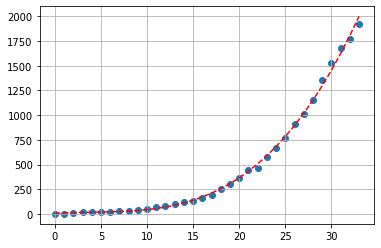

In [36]:
calculate_and_create_chart_for_province(START_DATE, 'Modena')

## Parma

Total cases per 1000 inhabitants up to today: 3.9029
Total cases up to today: 1752
New cases registered today: 62
New cases registered today in %: 3.67
Doubling time in the last five days: 13.8
Doubling time yesterday: 10.3
Trend of new cases (in %) in the last 5 days: 28.45


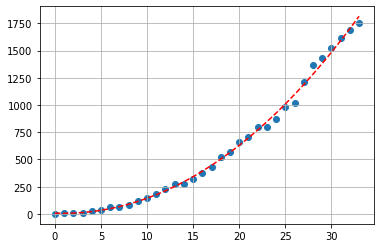

In [37]:
calculate_and_create_chart_for_province(START_DATE, 'Parma')

## Piacenza

Total cases per 1000 inhabitants up to today: 8.3346
Total cases up to today: 2390
New cases registered today: 114
New cases registered today in %: 5.01
Doubling time in the last five days: 14.6
Doubling time yesterday: 13.6
Trend of new cases (in %) in the last 5 days: 26.79


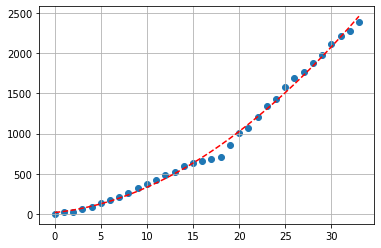

In [38]:
calculate_and_create_chart_for_province(START_DATE, 'Piacenza')

## Ravenna

Total cases per 1000 inhabitants up to today: 1.3311
Total cases up to today: 521
New cases registered today: 33
New cases registered today in %: 6.76
Doubling time in the last five days: 8.2
Doubling time yesterday: 7.6
Trend of new cases (in %) in the last 5 days: 52.34


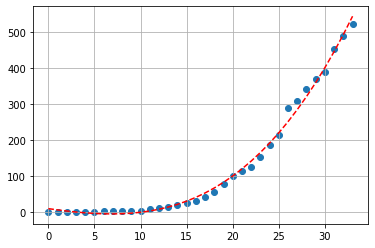

In [39]:
calculate_and_create_chart_for_province(START_DATE, 'Ravenna')

## Reggio nell'Emilia

Total cases per 1000 inhabitants up to today: 3.7485
Total cases up to today: 1996
New cases registered today: 135
New cases registered today in %: 7.25
Doubling time in the last five days: 9.2
Doubling time yesterday: 7.4
Trend of new cases (in %) in the last 5 days: 45.8


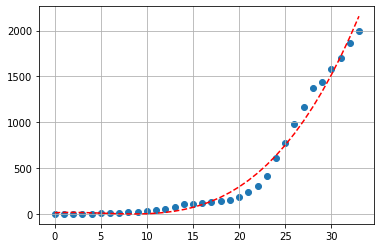

In [40]:
calculate_and_create_chart_for_province(START_DATE, "Reggio nell'Emilia")

## Rimini

Total cases per 1000 inhabitants up to today: 3.9283
Total cases up to today: 1323
New cases registered today: 59
New cases registered today in %: 4.67
Doubling time in the last five days: 14.1
Doubling time yesterday: 11.8
Trend of new cases (in %) in the last 5 days: 27.83


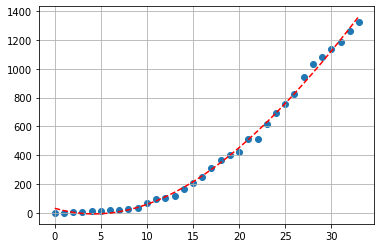

In [41]:
calculate_and_create_chart_for_province(START_DATE, 'Rimini')

# Casi di COVID-19 in Friuli Venezia Giulia - COVID-19 cases in Friuli Venezia Giulia

Total cases up to today: 1429
New cases registered today: 120
New cases registered today in %: 9.17
Doubling time in the last five days: 8.1
Doubling time yesterday: 8.4
Trend of new cases (in %) in the last 5 days: 53.66


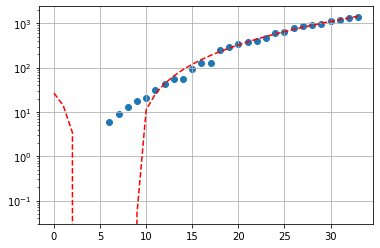

In [42]:
calculate_and_create_chart_for_region(START_DATE, 'Friuli Venezia Giulia')

## Gorizia

Total cases per 1000 inhabitants up to today: 0.6086
Total cases up to today: 85
New cases registered today: 6
New cases registered today in %: 7.59
Doubling time in the last five days: 8.0
Doubling time yesterday: 5.9
Trend of new cases (in %) in the last 5 days: 54.55


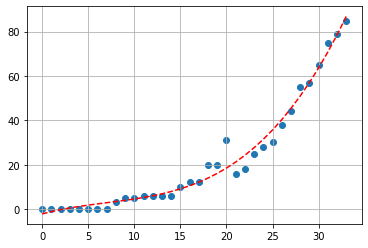

In [43]:
calculate_and_create_chart_for_province(START_DATE, 'Gorizia')

## Pordenone

Total cases per 1000 inhabitants up to today: 1.1601
Total cases up to today: 362
New cases registered today: 30
New cases registered today in %: 9.04
Doubling time in the last five days: 4.6
Doubling time yesterday: 5.0
Trend of new cases (in %) in the last 5 days: 112.94


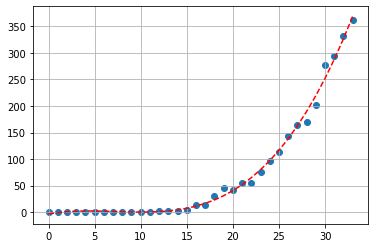

In [44]:
calculate_and_create_chart_for_province(START_DATE, 'Pordenone')

## Trieste

Total cases per 1000 inhabitants up to today: 1.926
Total cases up to today: 452
New cases registered today: 41
New cases registered today in %: 9.98
Doubling time in the last five days: 10.0
Doubling time yesterday: 10.7
Trend of new cases (in %) in the last 5 days: 41.25


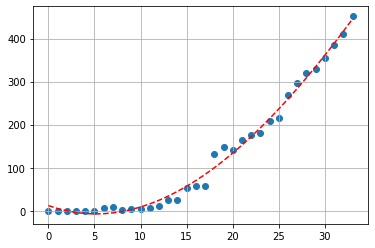

In [45]:
calculate_and_create_chart_for_province(START_DATE, 'Trieste')

## Udine

Total cases per 1000 inhabitants up to today: 0.9972
Total cases up to today: 530
New cases registered today: 43
New cases registered today in %: 8.83
Doubling time in the last five days: 10.8
Doubling time yesterday: 11.6
Trend of new cases (in %) in the last 5 days: 37.66


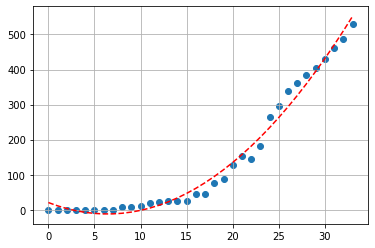

In [46]:
calculate_and_create_chart_for_province(START_DATE, 'Udine')

# Casi di COVID-19 nel Lazio - COVID-19 cases in Lazio

Total cases up to today: 2492
New cases registered today: 219
New cases registered today in %: 9.63
Doubling time in the last five days: 7.2
Doubling time yesterday: 6.9
Trend of new cases (in %) in the last 5 days: 62.24


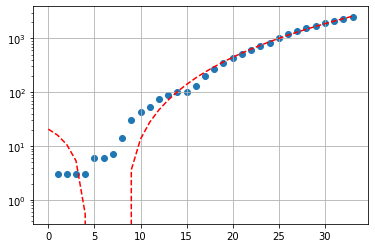

In [47]:
calculate_and_create_chart_for_region(START_DATE, 'Lazio')

## Frosinone

Total cases per 1000 inhabitants up to today: 0.4705
Total cases up to today: 232
New cases registered today: 41
New cases registered today in %: 21.47
Doubling time in the last five days: 3.3
Doubling time yesterday: 3.9
Trend of new cases (in %) in the last 5 days: 182.93


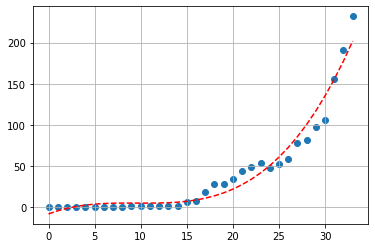

In [48]:
calculate_and_create_chart_for_province(START_DATE, 'Frosinone')

## Latina

Total cases per 1000 inhabitants up to today: 0.374
Total cases up to today: 215
New cases registered today: 3
New cases registered today in %: 1.42
Doubling time in the last five days: 11.5
Doubling time yesterday: 9.3
Trend of new cases (in %) in the last 5 days: 35.22


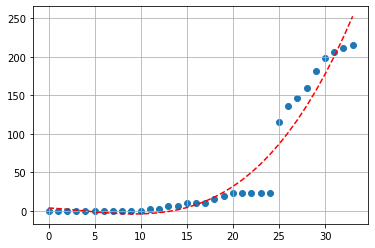

In [49]:
calculate_and_create_chart_for_province(START_DATE, 'Latina')

## Rieti

Total cases per 1000 inhabitants up to today: 0.3939
Total cases up to today: 62
New cases registered today: 19
New cases registered today in %: 44.19
Doubling time in the last five days: 5.0
Doubling time yesterday: 5.9
Trend of new cases (in %) in the last 5 days: 100.0


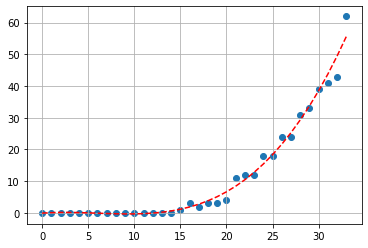

In [50]:
calculate_and_create_chart_for_province(START_DATE, 'Rieti')

## Roma

Total cases per 1000 inhabitants up to today: 0.4224
Total cases up to today: 1839
New cases registered today: 136
New cases registered today in %: 7.99
Doubling time in the last five days: 7.7
Doubling time yesterday: 7.2
Trend of new cases (in %) in the last 5 days: 57.05


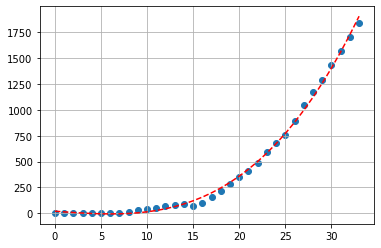

In [51]:
calculate_and_create_chart_for_province(START_DATE, 'Roma')

## Viterbo

Total cases per 1000 inhabitants up to today: 0.4514
Total cases up to today: 144
New cases registered today: 20
New cases registered today in %: 16.13
Doubling time in the last five days: 7.9
Doubling time yesterday: 8.4
Trend of new cases (in %) in the last 5 days: 54.84


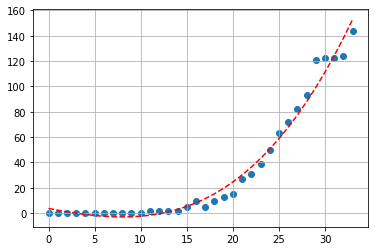

In [52]:
calculate_and_create_chart_for_province(START_DATE, 'Viterbo')

# Casi di COVID-19 in Liguria - COVID-19 cases in Liguria

Total cases up to today: 1568
New cases registered today: 101
New cases registered today in %: 6.88
Doubling time in the last five days: 11.0
Doubling time yesterday: 12.8
Trend of new cases (in %) in the last 5 days: 37.06


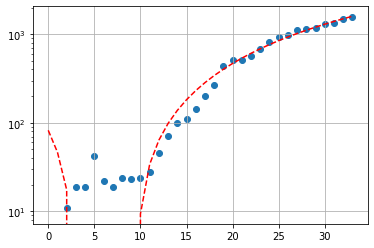

In [53]:
calculate_and_create_chart_for_region(START_DATE, 'Liguria')

## Genova

Total cases per 1000 inhabitants up to today: 1.034
Total cases up to today: 879
New cases registered today: 62
New cases registered today in %: 7.59
Doubling time in the last five days: 14.2
Doubling time yesterday: 18.4
Trend of new cases (in %) in the last 5 days: 27.58


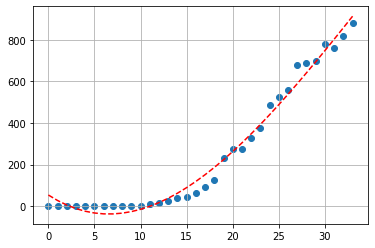

In [54]:
calculate_and_create_chart_for_province(START_DATE, 'Genova')

## Imperia

Total cases per 1000 inhabitants up to today: 1.097
Total cases up to today: 236
New cases registered today: 22
New cases registered today in %: 10.28
Doubling time in the last five days: 8.9
Doubling time yesterday: 14.3
Trend of new cases (in %) in the last 5 days: 47.5


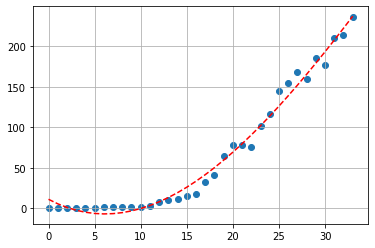

In [55]:
calculate_and_create_chart_for_province(START_DATE, 'Imperia')

## La Spezia

Total cases per 1000 inhabitants up to today: 1.0603
Total cases up to today: 234
New cases registered today: 21
New cases registered today in %: 9.86
Doubling time in the last five days: 4.6
Doubling time yesterday: 4.5
Trend of new cases (in %) in the last 5 days: 112.73


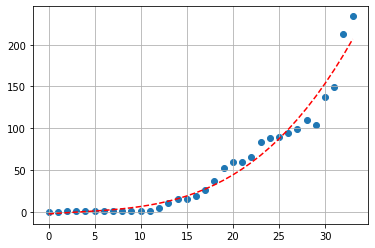

In [56]:
calculate_and_create_chart_for_province(START_DATE, 'La Spezia')

## Savona

Total cases per 1000 inhabitants up to today: 0.7838
Total cases up to today: 219
New cases registered today: -4
New cases registered today in %: -1.79
Doubling time in the last five days: 20.5
Doubling time yesterday: 14.3
Trend of new cases (in %) in the last 5 days: 18.38


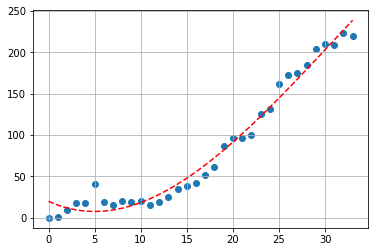

In [57]:
calculate_and_create_chart_for_province(START_DATE, 'Savona')

# Casi di COVID-19 in Lombardia - COVID-19 cases in Lombardy

Total cases up to today: 38266
New cases registered today: 1773
New cases registered today in %: 4.86
Doubling time in the last five days: 11.3
Doubling time yesterday: 10.9
Trend of new cases (in %) in the last 5 days: 35.95


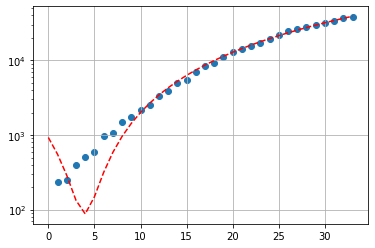

In [58]:
calculate_and_create_chart_for_region(START_DATE, 'Lombardia')

## Bergamo

Total cases per 1000 inhabitants up to today: 7.5221
Total cases up to today: 8349
New cases registered today: 289
New cases registered today in %: 3.59
Doubling time in the last five days: 13.6
Doubling time yesterday: 13.3
Trend of new cases (in %) in the last 5 days: 29.02


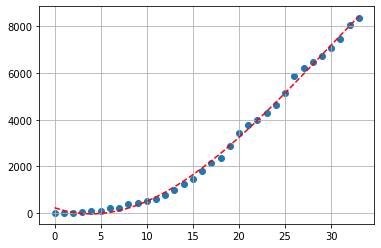

In [59]:
calculate_and_create_chart_for_province(START_DATE, 'Bergamo')

## Brescia

Total cases per 1000 inhabitants up to today: 6.0825
Total cases up to today: 7678
New cases registered today: 373
New cases registered today in %: 5.11
Doubling time in the last five days: 13.2
Doubling time yesterday: 10.9
Trend of new cases (in %) in the last 5 days: 30.03


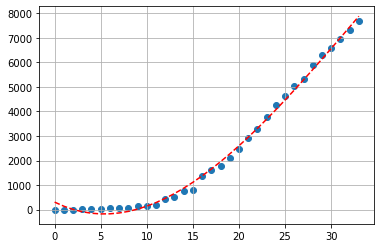

In [60]:
calculate_and_create_chart_for_province(START_DATE, 'Brescia')

## Como

Total cases per 1000 inhabitants up to today: 1.5045
Total cases up to today: 903
New cases registered today: 87
New cases registered today in %: 10.66
Doubling time in the last five days: 7.9
Doubling time yesterday: 7.4
Trend of new cases (in %) in the last 5 days: 55.42


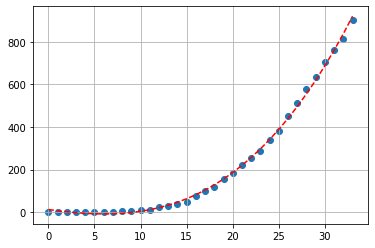

In [61]:
calculate_and_create_chart_for_province(START_DATE, 'Como')

## Cremona

Total cases per 1000 inhabitants up to today: 10.0309
Total cases up to today: 3605
New cases registered today: 109
New cases registered today in %: 3.12
Doubling time in the last five days: 16.6
Doubling time yesterday: 18.4
Trend of new cases (in %) in the last 5 days: 23.25


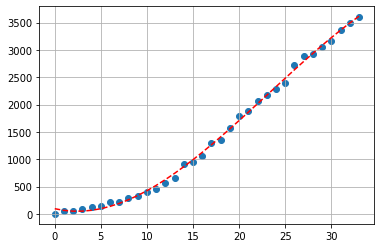

In [62]:
calculate_and_create_chart_for_province(START_DATE, 'Cremona')

## Lecco

Total cases per 1000 inhabitants up to today: 3.8793
Total cases up to today: 1316
New cases registered today: 106
New cases registered today in %: 8.76
Doubling time in the last five days: 10.1
Doubling time yesterday: 10.6
Trend of new cases (in %) in the last 5 days: 40.9


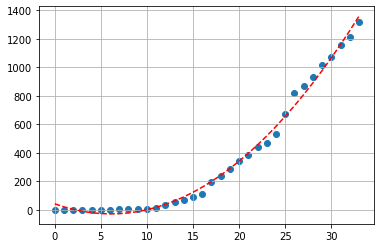

In [63]:
calculate_and_create_chart_for_province(START_DATE, 'Lecco')

## Lodi

Total cases per 1000 inhabitants up to today: 8.8472
Total cases up to today: 2029
New cases registered today: 23
New cases registered today in %: 1.15
Doubling time in the last five days: 31.4
Doubling time yesterday: 27.9
Trend of new cases (in %) in the last 5 days: 11.67


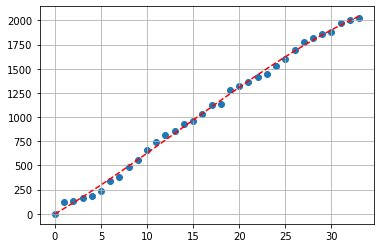

In [64]:
calculate_and_create_chart_for_province(START_DATE, 'Lodi')

## Mantova

Total cases per 1000 inhabitants up to today: 3.5966
Total cases up to today: 1484
New cases registered today: 86
New cases registered today in %: 6.15
Doubling time in the last five days: 8.5
Doubling time yesterday: 8.0
Trend of new cases (in %) in the last 5 days: 50.66


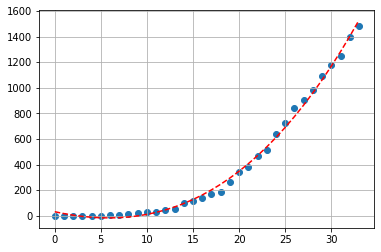

In [65]:
calculate_and_create_chart_for_province(START_DATE, 'Mantova')

## Milano

Total cases per 1000 inhabitants up to today: 2.4184
Total cases up to today: 7783
New cases registered today: 314
New cases registered today in %: 4.2
Doubling time in the last five days: 9.1
Doubling time yesterday: 9.1
Trend of new cases (in %) in the last 5 days: 46.13


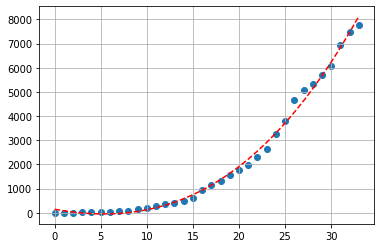

In [66]:
calculate_and_create_chart_for_province(START_DATE, 'Milano')

## Monza e della Brianza

Total cases per 1000 inhabitants up to today: 2.4008
Total cases up to today: 2086
New cases registered today: 138
New cases registered today in %: 7.08
Doubling time in the last five days: 5.7
Doubling time yesterday: 6.1
Trend of new cases (in %) in the last 5 days: 84.6


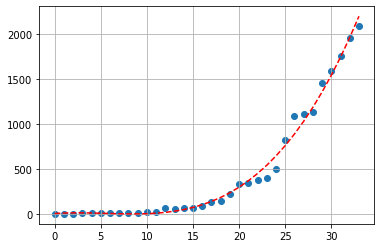

In [67]:
calculate_and_create_chart_for_province(START_DATE, 'Monza e della Brianza')

## Pavia

Total cases per 1000 inhabitants up to today: 3.4299
Total cases up to today: 1877
New cases registered today: 165
New cases registered today in %: 9.64
Doubling time in the last five days: 13.2
Doubling time yesterday: 12.8
Trend of new cases (in %) in the last 5 days: 29.99


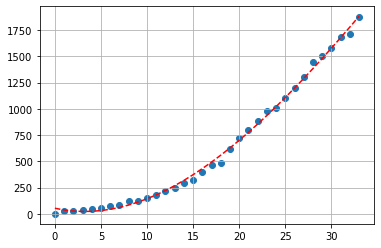

In [68]:
calculate_and_create_chart_for_province(START_DATE, 'Pavia')

## Sondrio

Total cases per 1000 inhabitants up to today: 2.1385
Total cases up to today: 388
New cases registered today: 26
New cases registered today in %: 7.18
Doubling time in the last five days: 5.6
Doubling time yesterday: 6.1
Trend of new cases (in %) in the last 5 days: 86.54


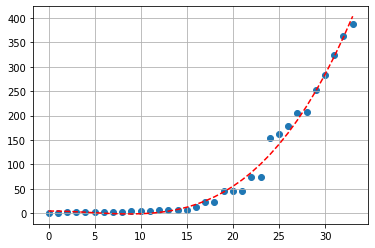

In [69]:
calculate_and_create_chart_for_province(START_DATE, 'Sondrio')

## Varese

Total cases per 1000 inhabitants up to today: 0.8629
Total cases up to today: 768
New cases registered today: 57
New cases registered today in %: 8.02
Doubling time in the last five days: 5.8
Doubling time yesterday: 5.7
Trend of new cases (in %) in the last 5 days: 82.42


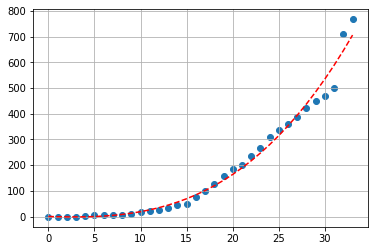

In [70]:
calculate_and_create_chart_for_province(START_DATE, 'Varese')

# Casi di COVID-19 nelle Marche - COVID-19 cases in Marche

Total cases up to today: 3312
New cases registered today: 170
New cases registered today in %: 5.41
Doubling time in the last five days: 12.9
Doubling time yesterday: 12.6
Trend of new cases (in %) in the last 5 days: 30.7


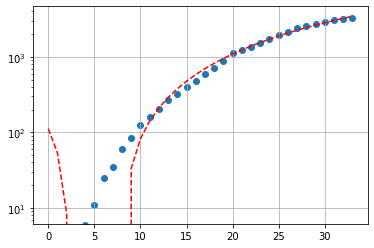

In [71]:
calculate_and_create_chart_for_region(START_DATE, 'Marche')

## Ancona

Total cases per 1000 inhabitants up to today: 1.991
Total cases up to today: 944
New cases registered today: 39
New cases registered today in %: 4.31
Doubling time in the last five days: 11.7
Doubling time yesterday: 11.9
Trend of new cases (in %) in the last 5 days: 34.47


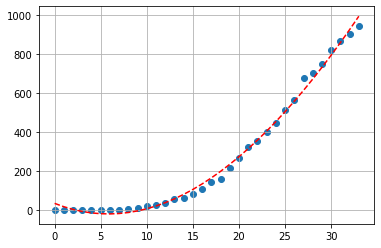

In [72]:
calculate_and_create_chart_for_province(START_DATE, 'Ancona')

## Ascoli Piceno

Total cases per 1000 inhabitants up to today: 0.7782
Total cases up to today: 163
New cases registered today: 45
New cases registered today in %: 38.14
Doubling time in the last five days: 3.5
Doubling time yesterday: 4.6
Trend of new cases (in %) in the last 5 days: 167.21


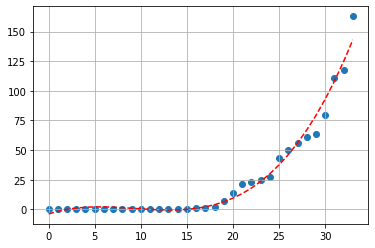

In [73]:
calculate_and_create_chart_for_province(START_DATE, 'Ascoli Piceno')

## Fermo

Total cases per 1000 inhabitants up to today: 1.3783
Total cases up to today: 241
New cases registered today: 8
New cases registered today in %: 3.43
Doubling time in the last five days: 5.8
Doubling time yesterday: 4.8
Trend of new cases (in %) in the last 5 days: 81.2


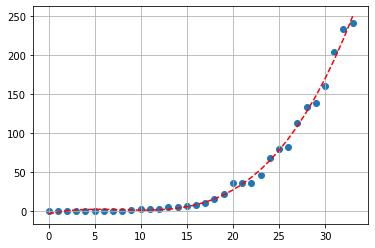

In [74]:
calculate_and_create_chart_for_province(START_DATE, 'Fermo')

## Macerata

Total cases per 1000 inhabitants up to today: 1.433
Total cases up to today: 457
New cases registered today: 46
New cases registered today in %: 11.19
Doubling time in the last five days: 10.3
Doubling time yesterday: 10.2
Trend of new cases (in %) in the last 5 days: 40.18


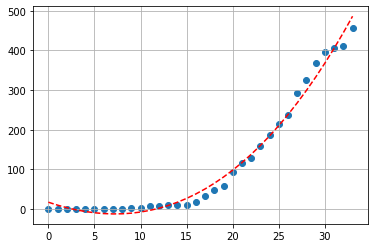

In [75]:
calculate_and_create_chart_for_province(START_DATE, 'Macerata')

## Pesaro e Urbino

Total cases per 1000 inhabitants up to today: 4.1779
Total cases up to today: 1507
New cases registered today: 32
New cases registered today in %: 2.17
Doubling time in the last five days: 25.0
Doubling time yesterday: 20.8
Trend of new cases (in %) in the last 5 days: 14.86


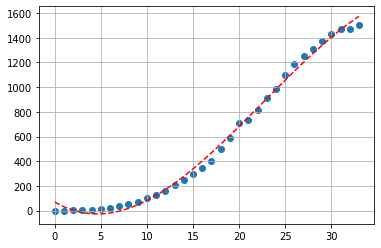

In [76]:
calculate_and_create_chart_for_province(START_DATE, 'Pesaro e Urbino')

# Casi di COVID-19 in Molise - COVID-19 cases in Molise¶

Total cases up to today: 110
New cases registered today: 10
New cases registered today in %: 10.0
Doubling time in the last five days: 5.4
Doubling time yesterday: 6.2
Trend of new cases (in %) in the last 5 days: 89.66


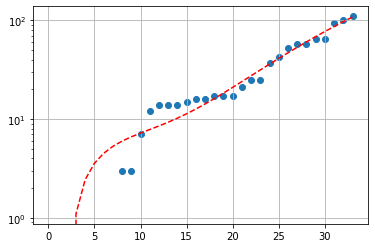

In [77]:
calculate_and_create_chart_for_region(START_DATE, 'Molise')

## Campobasso

Total cases per 1000 inhabitants up to today: 0.4318
Total cases up to today: 97
New cases registered today: 6
New cases registered today in %: 6.59
Doubling time in the last five days: 5.9
Doubling time yesterday: 6.4
Trend of new cases (in %) in the last 5 days: 79.63


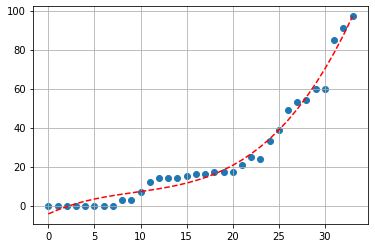

In [78]:
calculate_and_create_chart_for_province(START_DATE, 'Campobasso')

## Isernia

Total cases per 1000 inhabitants up to today: 0.1515
Total cases up to today: 13
New cases registered today: 4
New cases registered today in %: 44.44
Doubling time in the last five days: 2.9
Doubling time yesterday: 4.3
Trend of new cases (in %) in the last 5 days: 225.0


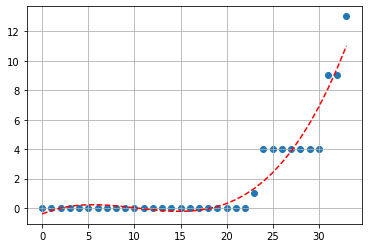

In [79]:
calculate_and_create_chart_for_province(START_DATE, 'Isernia')

# Casi di COVID-19 in Piemonte - COVID-19 cases in Piedmont 

Total cases up to today: 7492
New cases registered today: 582
New cases registered today in %: 8.42
Doubling time in the last five days: 7.5
Doubling time yesterday: 7.2
Trend of new cases (in %) in the last 5 days: 58.83


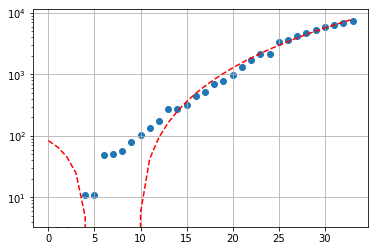

In [80]:
calculate_and_create_chart_for_region(START_DATE, 'Piemonte')

## Alessandria

Total cases per 1000 inhabitants up to today: 2.8055
Total cases up to today: 1197
New cases registered today: 91
New cases registered today in %: 8.23
Doubling time in the last five days: 9.1
Doubling time yesterday: 9.2
Trend of new cases (in %) in the last 5 days: 46.51


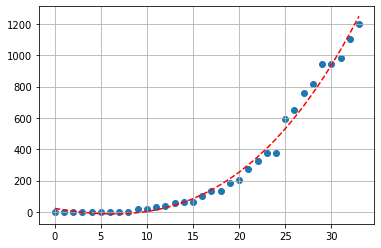

In [81]:
calculate_and_create_chart_for_province(START_DATE, 'Alessandria')

## Asti

Total cases per 1000 inhabitants up to today: 1.4676
Total cases up to today: 318
New cases registered today: 15
New cases registered today in %: 4.95
Doubling time in the last five days: 8.3
Doubling time yesterday: 6.7
Trend of new cases (in %) in the last 5 days: 52.15


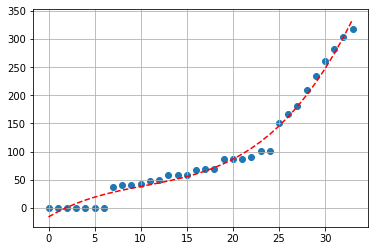

In [82]:
calculate_and_create_chart_for_province(START_DATE, 'Asti')

## Biella

Total cases per 1000 inhabitants up to today: 2.2347
Total cases up to today: 399
New cases registered today: 32
New cases registered today in %: 8.72
Doubling time in the last five days: 7.6
Doubling time yesterday: 8.4
Trend of new cases (in %) in the last 5 days: 57.71


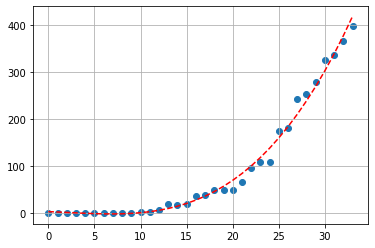

In [83]:
calculate_and_create_chart_for_province(START_DATE, 'Biella')

## Cuneo

Total cases per 1000 inhabitants up to today: 0.9472
Total cases up to today: 558
New cases registered today: 40
New cases registered today in %: 7.72
Doubling time in the last five days: 8.3
Doubling time yesterday: 6.5
Trend of new cases (in %) in the last 5 days: 52.04


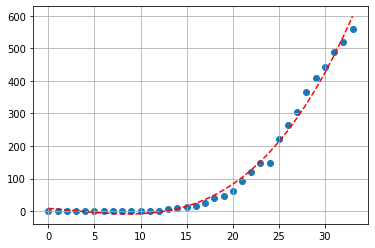

In [84]:
calculate_and_create_chart_for_province(START_DATE, 'Cuneo')

## Novara

Total cases per 1000 inhabitants up to today: 1.775
Total cases up to today: 657
New cases registered today: 48
New cases registered today in %: 7.88
Doubling time in the last five days: 7.7
Doubling time yesterday: 8.1
Trend of new cases (in %) in the last 5 days: 56.43


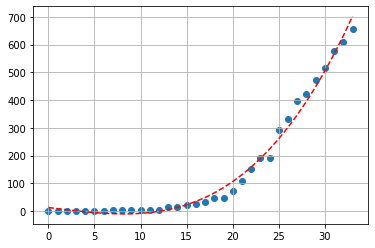

In [85]:
calculate_and_create_chart_for_province(START_DATE, 'Novara')

## Torino

Total cases per 1000 inhabitants up to today: 1.6059
Total cases up to today: 3658
New cases registered today: 297
New cases registered today in %: 8.84
Doubling time in the last five days: 6.8
Doubling time yesterday: 6.6
Trend of new cases (in %) in the last 5 days: 66.42


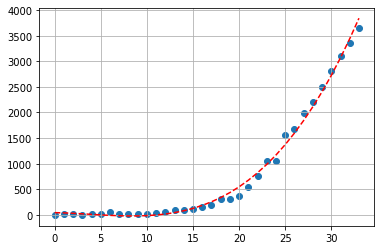

In [86]:
calculate_and_create_chart_for_province(START_DATE, 'Torino')

## 	Verbano-Cusio-Ossola

Total cases per 1000 inhabitants up to today: 1.9291
Total cases up to today: 308
New cases registered today: 20
New cases registered today in %: 6.94
Doubling time in the last five days: 7.2
Doubling time yesterday: 5.8
Trend of new cases (in %) in the last 5 days: 62.11


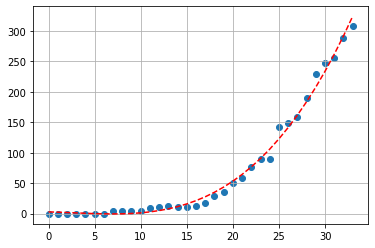

In [87]:
calculate_and_create_chart_for_province(START_DATE, 'Verbano-Cusio-Ossola')

## Vercelli

Total cases per 1000 inhabitants up to today: 2.2833
Total cases up to today: 397
New cases registered today: 39
New cases registered today in %: 10.89
Doubling time in the last five days: 8.4
Doubling time yesterday: 8.9
Trend of new cases (in %) in the last 5 days: 50.95


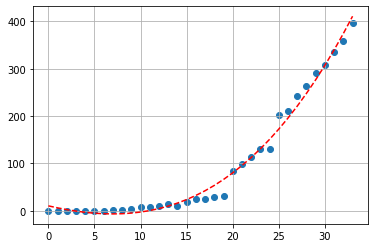

In [88]:
calculate_and_create_chart_for_province(START_DATE, 'Vercelli')

# Casi di COVID-19 in Puglia - COVID-19 cases in Apulia

Total cases up to today: 1400
New cases registered today: 121
New cases registered today in %: 9.46
Doubling time in the last five days: 6.9
Doubling time yesterday: 6.5
Trend of new cases (in %) in the last 5 days: 64.71


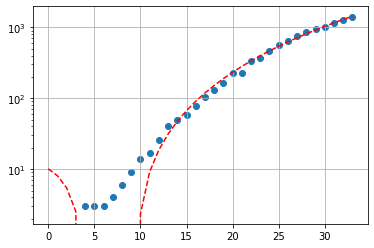

In [89]:
calculate_and_create_chart_for_region(START_DATE, 'Puglia')

## Bari

Total cases per 1000 inhabitants up to today: 0.3722
Total cases up to today: 469
New cases registered today: 25
New cases registered today in %: 5.63
Doubling time in the last five days: 6.2
Doubling time yesterday: 5.3
Trend of new cases (in %) in the last 5 days: 75.0


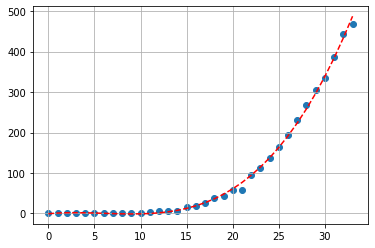

In [90]:
calculate_and_create_chart_for_province(START_DATE, 'Bari')

## 	Barletta-Andria-Trani

Total cases per 1000 inhabitants up to today: 0.2446
Total cases up to today: 96
New cases registered today: 4
New cases registered today in %: 4.35
Doubling time in the last five days: 7.1
Doubling time yesterday: 5.5
Trend of new cases (in %) in the last 5 days: 62.71


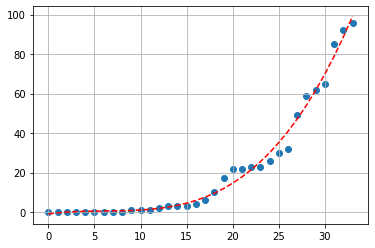

In [91]:
calculate_and_create_chart_for_province(START_DATE, 'Barletta-Andria-Trani')

## Brindisi

Total cases per 1000 inhabitants up to today: 0.3727
Total cases up to today: 148
New cases registered today: 23
New cases registered today in %: 18.4
Doubling time in the last five days: 9.3
Doubling time yesterday: 15.5
Trend of new cases (in %) in the last 5 days: 45.1


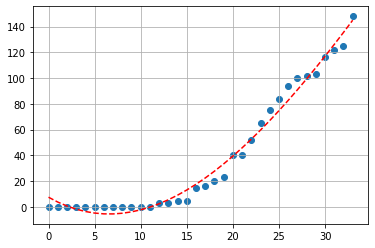

In [92]:
calculate_and_create_chart_for_province(START_DATE, 'Brindisi')

## Foggia

Total cases per 1000 inhabitants up to today: 0.5648
Total cases up to today: 355
New cases registered today: 30
New cases registered today in %: 9.23
Doubling time in the last five days: 7.7
Doubling time yesterday: 8.1
Trend of new cases (in %) in the last 5 days: 57.08


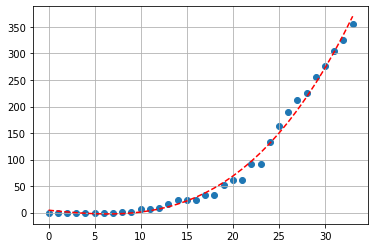

In [93]:
calculate_and_create_chart_for_province(START_DATE, 'Foggia')

## Lecce

Total cases per 1000 inhabitants up to today: 0.298
Total cases up to today: 239
New cases registered today: 24
New cases registered today in %: 11.16
Doubling time in the last five days: 7.3
Doubling time yesterday: 5.9
Trend of new cases (in %) in the last 5 days: 60.4


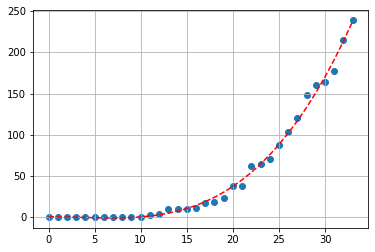

In [94]:
calculate_and_create_chart_for_province(START_DATE, 'Lecce')

## Taranto

Total cases per 1000 inhabitants up to today: 0.1594
Total cases up to today: 93
New cases registered today: 15
New cases registered today in %: 19.23
Doubling time in the last five days: 4.9
Doubling time yesterday: 5.4
Trend of new cases (in %) in the last 5 days: 102.17


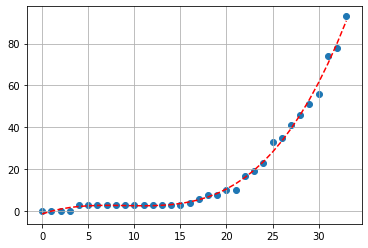

In [95]:
calculate_and_create_chart_for_province(START_DATE, 'Taranto')

# Casi di COVID-19 in Sardegna - COVID-19 cases in Sardinia

Total cases up to today: 624
New cases registered today: 94
New cases registered today in %: 17.74
Doubling time in the last five days: 6.3
Doubling time yesterday: 7.8
Trend of new cases (in %) in the last 5 days: 73.82


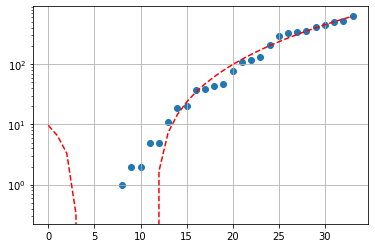

In [96]:
calculate_and_create_chart_for_region(START_DATE, 'Sardegna')

## Cagliari

Total cases per 1000 inhabitants up to today: 0.1731
Total cases up to today: 97
New cases registered today: 14
New cases registered today in %: 16.87
Doubling time in the last five days: 7.5
Doubling time yesterday: 7.4
Trend of new cases (in %) in the last 5 days: 59.02


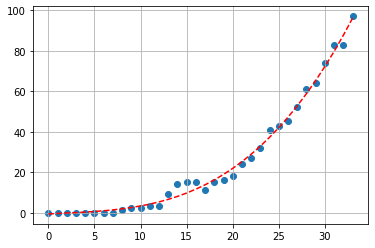

In [97]:
calculate_and_create_chart_for_province(START_DATE, 'Cagliari')

## Nuoro

Total cases per 1000 inhabitants up to today: 0.3588
Total cases up to today: 56
New cases registered today: 4
New cases registered today in %: 7.69
Doubling time in the last five days: 3.7
Doubling time yesterday: 4.0
Trend of new cases (in %) in the last 5 days: 154.55


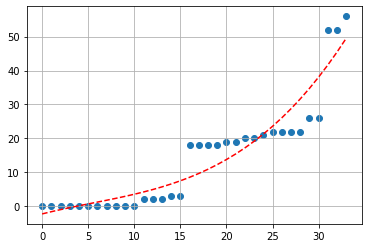

In [98]:
calculate_and_create_chart_for_province(START_DATE, 'Nuoro')

## Oristano

Total cases per 1000 inhabitants up to today: 0.056
Total cases up to today: 9
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 13.8
Doubling time yesterday: 4.3
Trend of new cases (in %) in the last 5 days: 28.57


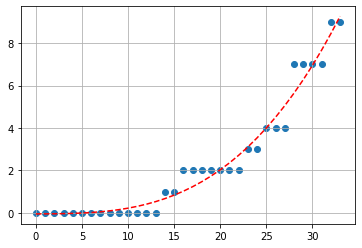

In [99]:
calculate_and_create_chart_for_province(START_DATE, 'Oristano')

## Sassari

Total cases per 1000 inhabitants up to today: 1.2218
Total cases up to today: 407
New cases registered today: 71
New cases registered today in %: 21.13
Doubling time in the last five days: 7.7
Doubling time yesterday: 12.2
Trend of new cases (in %) in the last 5 days: 56.54


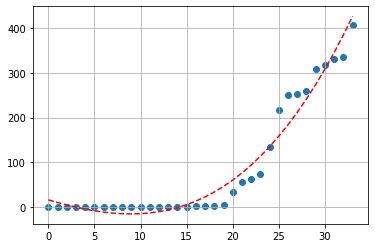

In [100]:
calculate_and_create_chart_for_province(START_DATE, 'Sassari')

# Casi di COVID-19 in Sicilia - COVID-19 cases in Sicily

Total cases up to today: 1359
New cases registered today: 109
New cases registered today in %: 8.72
Doubling time in the last five days: 5.5
Doubling time yesterday: 5.1
Trend of new cases (in %) in the last 5 days: 88.49


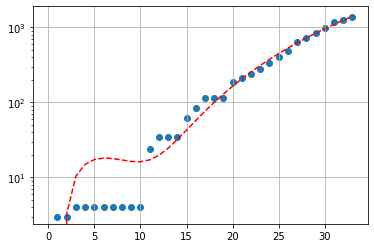

In [101]:
calculate_and_create_chart_for_region(START_DATE, 'Sicilia')

## Agrigento

Total cases per 1000 inhabitants up to today: 0.1312
Total cases up to today: 58
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 13.7
Doubling time yesterday: 10.0
Trend of new cases (in %) in the last 5 days: 28.89


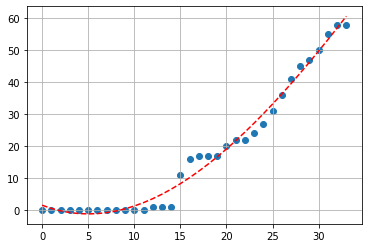

In [102]:
calculate_and_create_chart_for_province(START_DATE, 'Agrigento')

## Caltanissetta

Total cases per 1000 inhabitants up to today: 0.2113
Total cases up to today: 57
New cases registered today: 2
New cases registered today in %: 3.64
Doubling time in the last five days: 5.1
Doubling time yesterday: 4.9
Trend of new cases (in %) in the last 5 days: 96.55


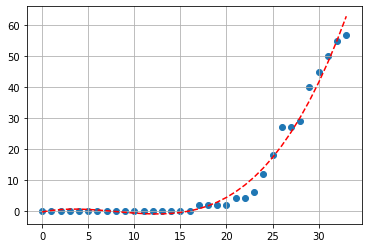

In [103]:
calculate_and_create_chart_for_province(START_DATE, 'Caltanissetta')

## Catania

Total cases per 1000 inhabitants up to today: 0.3476
Total cases up to today: 387
New cases registered today: 22
New cases registered today in %: 6.03
Doubling time in the last five days: 10.0
Doubling time yesterday: 7.8
Trend of new cases (in %) in the last 5 days: 41.24


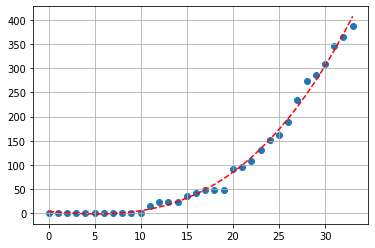

In [104]:
calculate_and_create_chart_for_province(START_DATE, 'Catania')

## Enna

Total cases per 1000 inhabitants up to today: 0.9997
Total cases up to today: 168
New cases registered today: 13
New cases registered today in %: 8.39
Doubling time in the last five days: 2.6
Doubling time yesterday: 2.3
Trend of new cases (in %) in the last 5 days: 281.82


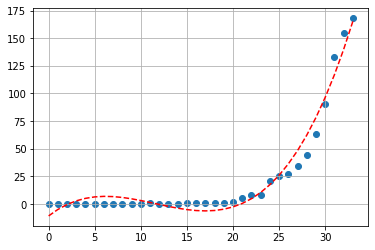

In [105]:
calculate_and_create_chart_for_province(START_DATE, 'Enna')

## Messina

Total cases per 1000 inhabitants up to today: 0.4382
Total cases up to today: 279
New cases registered today: 52
New cases registered today in %: 22.91
Doubling time in the last five days: 4.1
Doubling time yesterday: 4.9
Trend of new cases (in %) in the last 5 days: 132.5


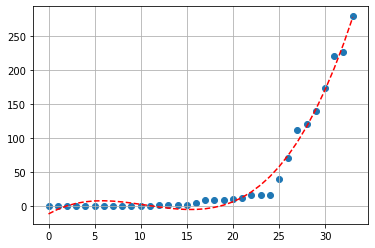

In [106]:
calculate_and_create_chart_for_province(START_DATE, 'Messina')

## Palermo

Total cases per 1000 inhabitants up to today: 0.1829
Total cases up to today: 232
New cases registered today: 14
New cases registered today in %: 6.42
Doubling time in the last five days: 4.6
Doubling time yesterday: 4.0
Trend of new cases (in %) in the last 5 days: 112.84


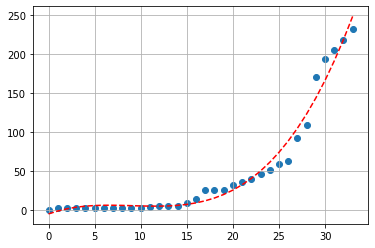

In [107]:
calculate_and_create_chart_for_province(START_DATE, 'Palermo')

## Ragusa

Total cases per 1000 inhabitants up to today: 0.0996
Total cases up to today: 32
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 2.7
Doubling time yesterday: 2.7
Trend of new cases (in %) in the last 5 days: 255.56


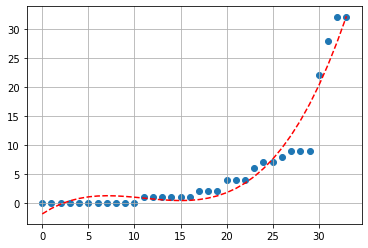

In [108]:
calculate_and_create_chart_for_province(START_DATE, 'Ragusa')

## Siracusa

Total cases per 1000 inhabitants up to today: 0.2085
Total cases up to today: 84
New cases registered today: 5
New cases registered today in %: 6.33
Doubling time in the last five days: 6.4
Doubling time yesterday: 7.3
Trend of new cases (in %) in the last 5 days: 71.43


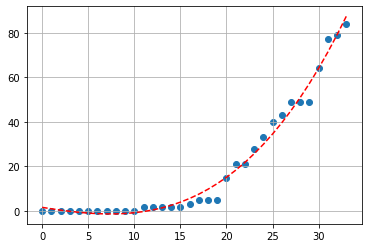

In [109]:
calculate_and_create_chart_for_province(START_DATE, 'Siracusa')

## Trapani

Total cases per 1000 inhabitants up to today: 0.1427
Total cases up to today: 62
New cases registered today: 1
New cases registered today in %: 1.64
Doubling time in the last five days: 8.9
Doubling time yesterday: 5.4
Trend of new cases (in %) in the last 5 days: 47.62


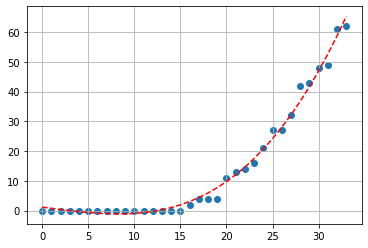

In [110]:
calculate_and_create_chart_for_province(START_DATE, 'Trapani')

# Casi di COVID-19 in Toscana - COVID-19 cases in Tuscany

Total cases up to today: 3817
New cases registered today: 296
New cases registered today in %: 8.41
Doubling time in the last five days: 7.9
Doubling time yesterday: 8.0
Trend of new cases (in %) in the last 5 days: 55.1


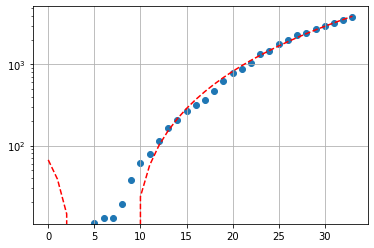

In [111]:
calculate_and_create_chart_for_region(START_DATE, 'Toscana')

## Arezzo

Total cases per 1000 inhabitants up to today: 0.7898
Total cases up to today: 272
New cases registered today: 12
New cases registered today in %: 4.62
Doubling time in the last five days: 11.5
Doubling time yesterday: 6.6
Trend of new cases (in %) in the last 5 days: 35.32


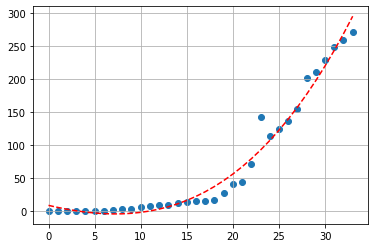

In [112]:
calculate_and_create_chart_for_province(START_DATE, 'Arezzo')

## Firenze

Total cases per 1000 inhabitants up to today: 0.8428
Total cases up to today: 855
New cases registered today: 46
New cases registered today in %: 5.69
Doubling time in the last five days: 7.8
Doubling time yesterday: 7.6
Trend of new cases (in %) in the last 5 days: 56.02


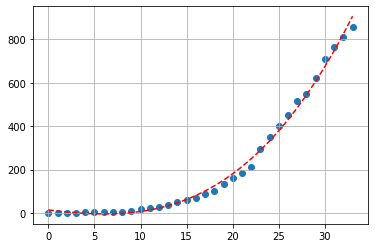

In [113]:
calculate_and_create_chart_for_province(START_DATE, 'Firenze')

## Grosseto

Total cases per 1000 inhabitants up to today: 1.0491
Total cases up to today: 234
New cases registered today: 30
New cases registered today in %: 14.71
Doubling time in the last five days: 5.7
Doubling time yesterday: 6.5
Trend of new cases (in %) in the last 5 days: 82.81


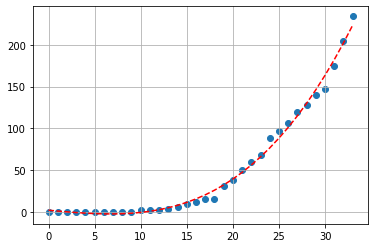

In [114]:
calculate_and_create_chart_for_province(START_DATE, 'Grosseto')

## Livorno

Total cases per 1000 inhabitants up to today: 0.6522
Total cases up to today: 220
New cases registered today: 8
New cases registered today in %: 3.77
Doubling time in the last five days: 7.7
Doubling time yesterday: 7.1
Trend of new cases (in %) in the last 5 days: 57.14


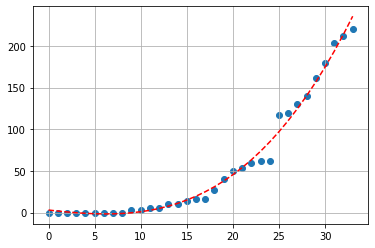

In [115]:
calculate_and_create_chart_for_province(START_DATE, 'Livorno')

## Lucca

Total cases per 1000 inhabitants up to today: 1.5844
Total cases up to today: 618
New cases registered today: 69
New cases registered today in %: 12.57
Doubling time in the last five days: 6.5
Doubling time yesterday: 8.0
Trend of new cases (in %) in the last 5 days: 70.25


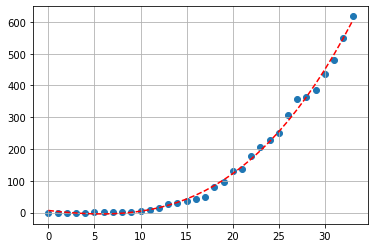

In [116]:
calculate_and_create_chart_for_province(START_DATE, 'Lucca')

## Massa Carrara

Total cases per 1000 inhabitants up to today: 2.3909
Total cases up to today: 470
New cases registered today: 68
New cases registered today in %: 16.92
Doubling time in the last five days: 7.1
Doubling time yesterday: 9.7
Trend of new cases (in %) in the last 5 days: 62.63


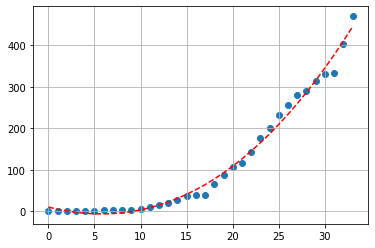

In [117]:
calculate_and_create_chart_for_province(START_DATE, 'Massa Carrara')

## Pisa

Total cases per 1000 inhabitants up to today: 0.9435
Total cases up to today: 398
New cases registered today: 24
New cases registered today in %: 6.42
Doubling time in the last five days: 8.6
Doubling time yesterday: 7.4
Trend of new cases (in %) in the last 5 days: 49.62


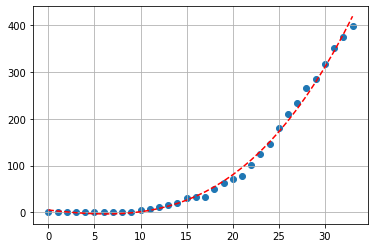

In [118]:
calculate_and_create_chart_for_province(START_DATE, 'Pisa')

## Pistoia

Total cases per 1000 inhabitants up to today: 1.0211
Total cases up to today: 298
New cases registered today: 17
New cases registered today in %: 6.05
Doubling time in the last five days: 13.2
Doubling time yesterday: 12.9
Trend of new cases (in %) in the last 5 days: 30.13


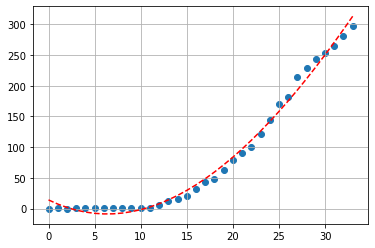

In [119]:
calculate_and_create_chart_for_province(START_DATE, 'Pistoia')

## Prato

Total cases per 1000 inhabitants up to today: 0.8523
Total cases up to today: 217
New cases registered today: 14
New cases registered today in %: 6.9
Doubling time in the last five days: 7.5
Doubling time yesterday: 7.6
Trend of new cases (in %) in the last 5 days: 58.39


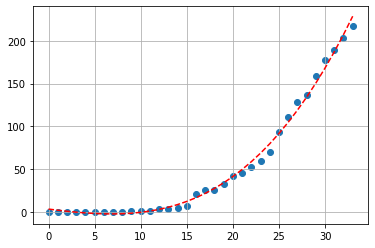

In [120]:
calculate_and_create_chart_for_province(START_DATE, 'Prato')

## Siena

Total cases per 1000 inhabitants up to today: 0.8758
Total cases up to today: 235
New cases registered today: 10
New cases registered today in %: 4.44
Doubling time in the last five days: 9.0
Doubling time yesterday: 7.8
Trend of new cases (in %) in the last 5 days: 46.88


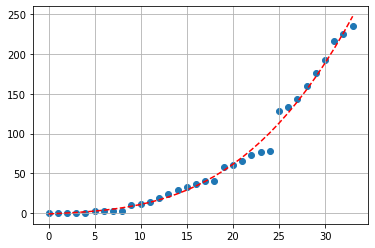

In [121]:
calculate_and_create_chart_for_province(START_DATE, 'Siena')

# Casi di COVID-19 in Provincia Autonoma di Trento - COVID-19 cases in the Autonomous Province of Trento

Total cases per 1000 inhabitants up to today: 2.7943
Total cases up to today: 1505
New cases registered today: 114
New cases registered today in %: 8.2
Doubling time in the last five days: 9.0
Doubling time yesterday: 9.2
Trend of new cases (in %) in the last 5 days: 47.12


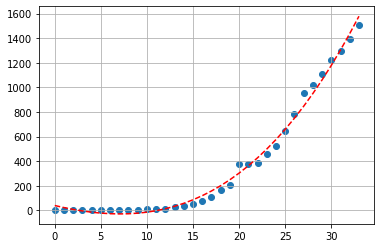

In [122]:
calculate_and_create_chart_for_province(START_DATE, 'Trento')

# Casi di COVID-19 in Umbria - COVID-19 cases in Umbria

Total cases up to today: 942
New cases registered today: 89
New cases registered today in %: 10.43
Doubling time in the last five days: 6.6
Doubling time yesterday: 6.6
Trend of new cases (in %) in the last 5 days: 68.82


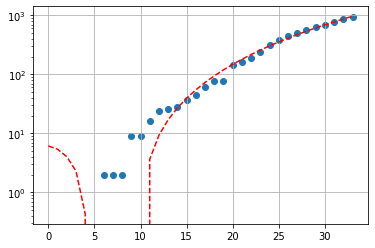

In [123]:
calculate_and_create_chart_for_region(START_DATE, 'Umbria')

## Perugia

Total cases per 1000 inhabitants up to today: 1.1034
Total cases up to today: 729
New cases registered today: 71
New cases registered today in %: 10.79
Doubling time in the last five days: 6.4
Doubling time yesterday: 6.2
Trend of new cases (in %) in the last 5 days: 71.93


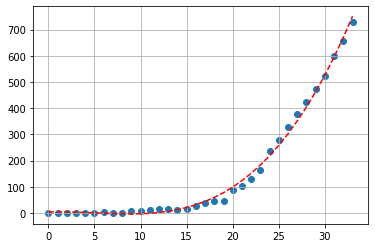

In [124]:
calculate_and_create_chart_for_province(START_DATE, 'Perugia')

## Terni

Total cases per 1000 inhabitants up to today: 0.9333
Total cases up to today: 213
New cases registered today: 18
New cases registered today in %: 9.23
Doubling time in the last five days: 7.5
Doubling time yesterday: 8.2
Trend of new cases (in %) in the last 5 days: 58.96


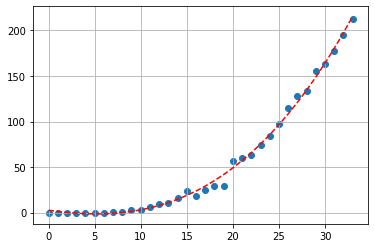

In [125]:
calculate_and_create_chart_for_province(START_DATE, 'Terni')

# Casi di COVID-19 in Valle d'Aosta - COVID-19 cases in Aosta Valley

Total cases per 1000 inhabitants up to today: 4.0273
Total cases up to today: 511
New cases registered today: 59
New cases registered today in %: 13.05
Doubling time in the last five days: 13.2
Doubling time yesterday: 16.0
Trend of new cases (in %) in the last 5 days: 30.03


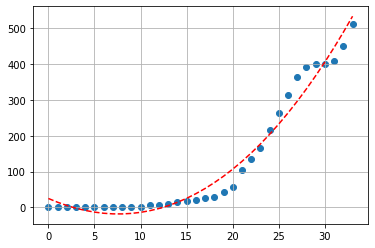

In [126]:
calculate_and_create_chart_for_province(START_DATE, "Aosta")

# Casi di COVID-19 in Veneto - COVID-19 cases in Veneto

Total cases up to today: 7666
New cases registered today: 448
New cases registered today in %: 6.21
Doubling time in the last five days: 9.4
Doubling time yesterday: 9.1
Trend of new cases (in %) in the last 5 days: 44.83


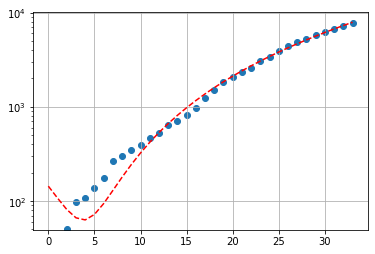

In [127]:
calculate_and_create_chart_for_region(START_DATE, 'Veneto')

## Belluno

Total cases per 1000 inhabitants up to today: 1.7834
Total cases up to today: 367
New cases registered today: 38
New cases registered today in %: 11.55
Doubling time in the last five days: 9.4
Doubling time yesterday: 9.2
Trend of new cases (in %) in the last 5 days: 44.49


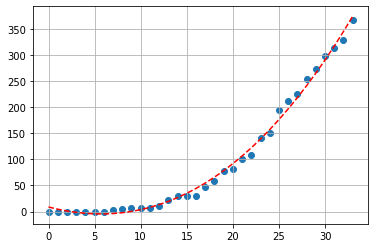

In [128]:
calculate_and_create_chart_for_province(START_DATE, 'Belluno')

## Padova

Total cases per 1000 inhabitants up to today: 2.1457
Total cases up to today: 2009
New cases registered today: 118
New cases registered today in %: 6.24
Doubling time in the last five days: 9.1
Doubling time yesterday: 8.8
Trend of new cases (in %) in the last 5 days: 46.54


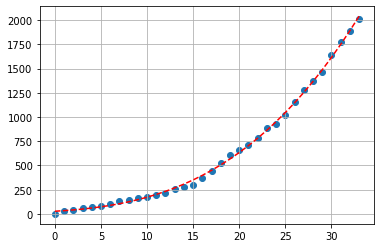

In [129]:
calculate_and_create_chart_for_province(START_DATE, 'Padova')

## Rovigo

Total cases per 1000 inhabitants up to today: 0.5113
Total cases up to today: 122
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 8.2
Doubling time yesterday: 7.3
Trend of new cases (in %) in the last 5 days: 52.5


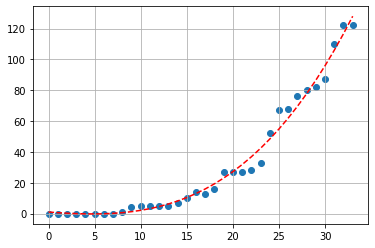

In [130]:
calculate_and_create_chart_for_province(START_DATE, 'Rovigo')

## Treviso

Total cases per 1000 inhabitants up to today: 1.5339
Total cases up to today: 1359
New cases registered today: 49
New cases registered today in %: 3.74
Doubling time in the last five days: 11.3
Doubling time yesterday: 10.3
Trend of new cases (in %) in the last 5 days: 36.04


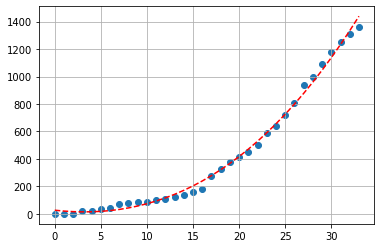

In [131]:
calculate_and_create_chart_for_province(START_DATE, 'Treviso')

## Venezia

Total cases per 1000 inhabitants up to today: 1.1928
Total cases up to today: 1019
New cases registered today: 64
New cases registered today in %: 6.7
Doubling time in the last five days: 14.2
Doubling time yesterday: 13.0
Trend of new cases (in %) in the last 5 days: 27.53


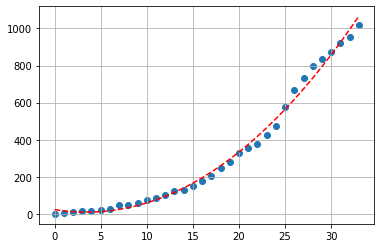

In [132]:
calculate_and_create_chart_for_province(START_DATE, 'Venezia')

## Verona

Total cases per 1000 inhabitants up to today: 1.9033
Total cases up to today: 1754
New cases registered today: 109
New cases registered today in %: 6.63
Doubling time in the last five days: 7.4
Doubling time yesterday: 7.7
Trend of new cases (in %) in the last 5 days: 59.6


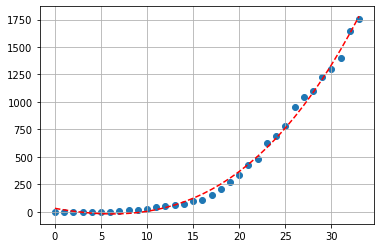

In [133]:
calculate_and_create_chart_for_province(START_DATE, 'Verona')

## Vicenza

Total cases per 1000 inhabitants up to today: 1.1976
Total cases up to today: 1036
New cases registered today: 70
New cases registered today in %: 7.25
Doubling time in the last five days: 8.6
Doubling time yesterday: 8.1
Trend of new cases (in %) in the last 5 days: 49.93


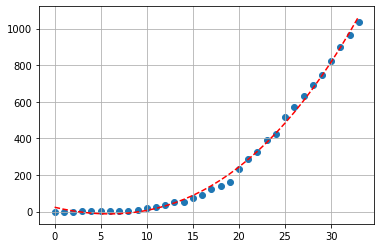

In [134]:
calculate_and_create_chart_for_province(START_DATE, 'Vicenza')